In [1]:
import tensorflow
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from keras import utils,Sequential
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Rescaling,RandomFlip,RandomRotation,RandomZoom,Lambda
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW

In [3]:
import kagglehub

path=kagglehub.dataset_download("fahadullaha/facial-emotion-recognition-dataset")
print("Path to dataset files:",path)

100%|██████████| 200M/200M [00:15<00:00, 13.9MB/s] 

Extracting files...


Path to dataset files: /Users/hades/.cache/kagglehub/datasets/fahadullaha/facial-emotion-recognition-dataset/versions/1


In [4]:
import os

print("Dataset Path:",path)
print("Files:",os.listdir(path))

Dataset Path: /Users/hades/.cache/kagglehub/datasets/fahadullaha/facial-emotion-recognition-dataset/versions/1
Files: ['processed_data']


In [5]:
train_data=utils.image_dataset_from_directory(
    directory=f'{path}/processed_data',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256),
    seed=42,
    shuffle=True,
    validation_split=0.2,
    subset='training'
)

validation=utils.image_dataset_from_directory(
    directory=f'{path}/processed_data',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256),
    shuffle=False,
    validation_split=0.2,
    subset='validation'
)

classes=train_data.class_names
classes

Found 49779 files belonging to 7 classes.
Using 39824 files for training.
Found 49779 files belonging to 7 classes.
Using 9955 files for validation.


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
train_data=train_data.apply(tensorflow.data.experimental.ignore_errors())
validation=validation.apply(tensorflow.data.experimental.ignore_errors())

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


tf.Tensor([4 6 3 0 6 6 4 3 3 0 2 4 4 2 4 6 2 6 5 6 3 5 1 6 3 4 3 0 3 3 2 3], shape=(32,), dtype=int32)


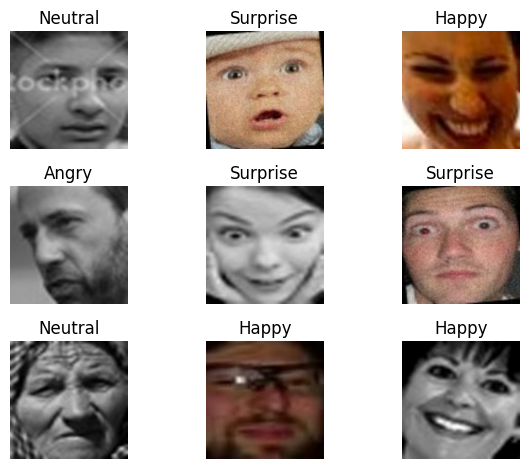

In [7]:
images,labels=next(iter(train_data))

print(labels[:])

expression={
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Neutral',
    5:'Sad',
    6:'Surprise'
}

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(expression[int(labels[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()
    

In [5]:
foundational_model=ResNet50(
    weights='imagenet',
    input_shape=(256,256,3),
    include_top=False
)

for layer in foundational_model.layers:
    layer.trainable=False

data_augmentation=Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

for layer in foundational_model.layers[-40:]:
    layer.trainable=True


model=Sequential([
    data_augmentation,
    # Rescaling(1./255),   ##didnt worked since resnet50 was preprocessed differently hence used preprocess_input which is the same preprocessing of Res
    Lambda(preprocess_input),
    foundational_model,
    GlobalAveragePooling2D(),

    Dense(512,activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(256,activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(7,activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 15,831,808 (60.39 MB)

 Non-trainable params: 7,755,904 (29.59 MB)

In [7]:
model.compile(
    # optimizer=AdamW(learning_rate=3e-5, weight_decay=1e-4),
    optimizer='adamW',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

reduce_lr=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [9]:
history=model.fit(train_data,
                   epochs=30,
                  validation_data=validation,
                  callbacks=[early_stopping,reduce_lr]
                 )

Epoch 1/30


I0000 00:00:1762709537.536088      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1245/Unknown 196s 141ms/step - accuracy: 0.4356 - loss: 1.6288

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 226s 165ms/step - accuracy: 0.4356 - loss: 1.6286 - val_accuracy: 0.7845 - val_loss: 0.7571 - learning_rate: 0.0010
Epoch 2/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 205s 164ms/step - accuracy: 0.5953 - loss: 1.0803 - val_accuracy: 0.7050 - val_loss: 0.8445 - learning_rate: 0.0010
Epoch 3/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 206s 165ms/step - accuracy: 0.6385 - loss: 0.9837 - val_accuracy: 0.7291 - val_loss: 0.7400 - learning_rate: 0.0010
Epoch 4/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 206s 165ms/step - accuracy: 0.6642 - loss: 0.9213 - val_accuracy: 0.6995 - val_loss: 0.8159 - learning_rate: 0.0010
Epoch 5/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 207s 166ms/step - accuracy: 0.6717 - loss: 0.8803 - val_accuracy: 0.7031 - val_loss: 0.8223 - learning_rate: 0.0010
Epoch 6/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 207s 167ms/step - accuracy: 0.6947 - loss: 0.8367 - val_accuracy: 0.6955 - val_loss: 0.8685 - learning_rate: 0.0010
Epoch 7/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 207s 166ms/step - acc

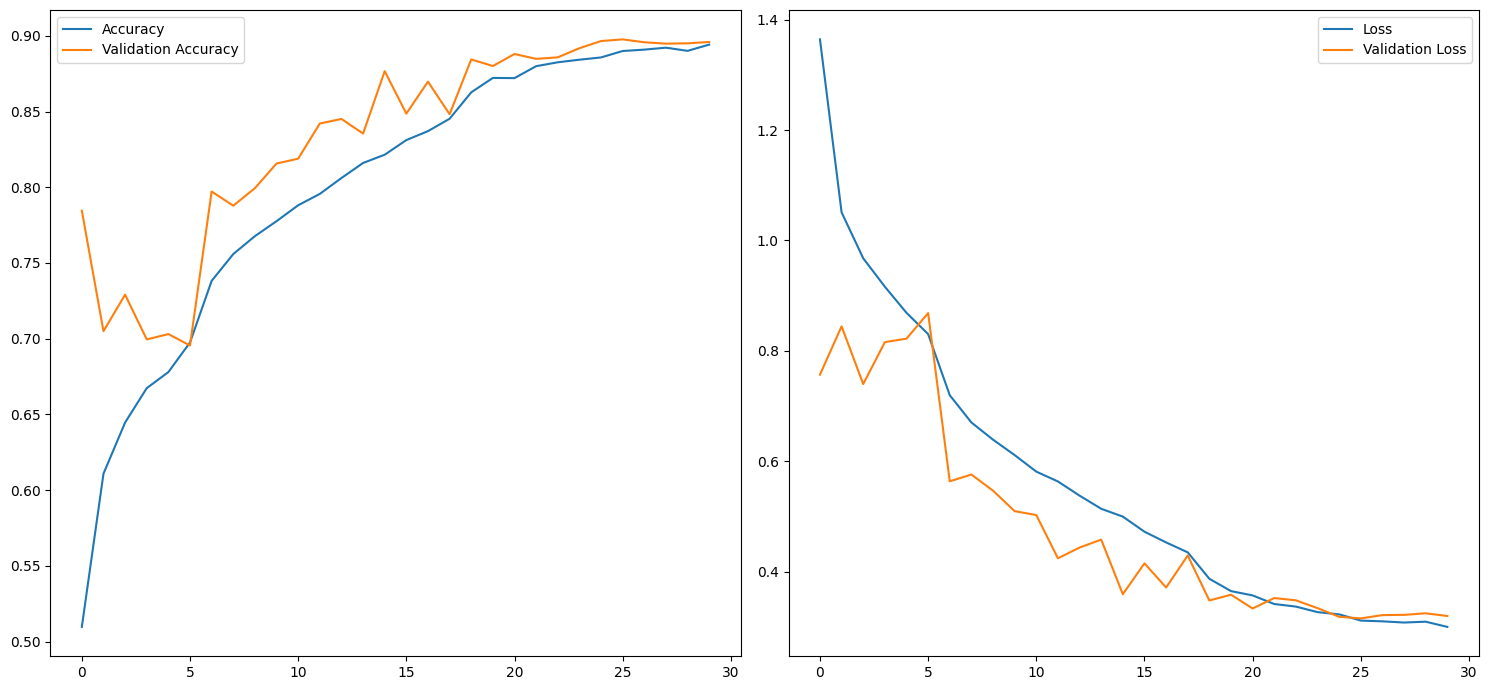

In [10]:
fig,axes=plt.subplots(1,2,figsize=(15,7))

axes[0].plot(history.history['accuracy'],label='Accuracy')
axes[0].plot(history.history['val_accuracy'],label='Validation Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'],label='Loss')
axes[1].plot(history.history['val_loss'],label='Validation Loss')
axes[1].legend()


fig.tight_layout()
fig.show()

Fine tuning our stabalized model further

In [11]:
for layers in foundational_model.layers[-50:]:
    layers.trainable=True

In [12]:
model.compile(
    optimizer='adamW',
    metrics=['accuracy'],
    loss='sparse_categorical_crossentropy'
)

In [13]:
history_1=model.fit(
    train_data,
    epochs=10,
    validation_data=validation,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 241s 180ms/step - accuracy: 0.7429 - loss: 0.7202 - val_accuracy: 0.7173 - val_loss: 0.7232 - learning_rate: 0.0010
Epoch 2/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 221s 177ms/step - accuracy: 0.7490 - loss: 0.6897 - val_accuracy: 0.7612 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 3/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 220s 177ms/step - accuracy: 0.7556 - loss: 0.6718 - val_accuracy: 0.7990 - val_loss: 0.5771 - learning_rate: 0.0010
Epoch 4/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 221s 177ms/step - accuracy: 0.7667 - loss: 0.6430 - val_accuracy: 0.8534 - val_loss: 0.4149 - learning_rate: 0.0010
Epoch 5/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 220s 177ms/step - accuracy: 0.7751 - loss: 0.6220 - val_accuracy: 0.8059 - val_loss: 0.5420 - learning_rate: 0.0010
Epoch 6/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 220s 177ms/step - accuracy: 0.7858 - loss: 0.5888 - val_accuracy: 0.8497 - val_loss: 0.4574 - learning_rate: 0.0010
Epoch 7/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 220s 177ms

In [14]:
history_2=model.fit(
    train_data,
    epochs=20,
    initial_epoch=10,
    validation_data=validation,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 11/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 220s 177ms/step - accuracy: 0.8758 - loss: 0.3534 - val_accuracy: 0.8889 - val_loss: 0.3223 - learning_rate: 2.0000e-04
Epoch 12/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 221s 177ms/step - accuracy: 0.8839 - loss: 0.3264 - val_accuracy: 0.8884 - val_loss: 0.3401 - learning_rate: 2.0000e-04
Epoch 13/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 220s 177ms/step - accuracy: 0.8894 - loss: 0.3151 - val_accuracy: 0.8913 - val_loss: 0.3338 - learning_rate: 2.0000e-04
Epoch 14/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 220s 176ms/step - accuracy: 0.8929 - loss: 0.3025 - val_accuracy: 0.8872 - val_loss: 0.3634 - learning_rate: 2.0000e-04
Epoch 15/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 220s 177ms/step - accuracy: 0.9069 - loss: 0.2712 - val_accuracy: 0.9121 - val_loss: 0.2827 - learning_rate: 4.0000e-05
Epoch 16/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 220s 177ms/step - accuracy: 0.9086 - loss: 0.2614 - val_accuracy: 0.9140 - val_loss: 0.2768 - learning_rate: 4.0000e-05
Epoch 17/20
1245/1245 

In [15]:
history_3=model.fit(
    train_data,
    validation_data=validation,
    epochs=35,
    initial_epoch=20,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 21/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 221s 177ms/step - accuracy: 0.9186 - loss: 0.2288 - val_accuracy: 0.9251 - val_loss: 0.2443 - learning_rate: 4.0000e-05
Epoch 22/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 221s 177ms/step - accuracy: 0.9232 - loss: 0.2222 - val_accuracy: 0.9208 - val_loss: 0.2612 - learning_rate: 4.0000e-05
Epoch 23/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 221s 177ms/step - accuracy: 0.9223 - loss: 0.2257 - val_accuracy: 0.9192 - val_loss: 0.2677 - learning_rate: 4.0000e-05
Epoch 24/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 220s 177ms/step - accuracy: 0.9245 - loss: 0.2164 - val_accuracy: 0.9265 - val_loss: 0.2492 - learning_rate: 4.0000e-05
Epoch 25/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 221s 177ms/step - accuracy: 0.9238 - loss: 0.2187 - val_accuracy: 0.9237 - val_loss: 0.2568 - learning_rate: 8.0000e-06
Epoch 26/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 221s 177ms/step - accuracy: 0.9294 - loss: 0.2065 - val_accuracy: 0.9257 - val_loss: 0.2517 - learning_rate: 8.0000e-06
Epoch 26: early stoppi

In [16]:
for layers in foundational_model.layers[-60:]:
    layers.trainable=True


model.compile(
    optimizer=AdamW(learning_rate=8e-6,weight_decay=1e-4),
    metrics=['accuracy'],
    loss='sparse_categorical_crossentropy'
)

In [17]:
history_4=model.fit(
    train_data,
    validation_data=validation,
    epochs=35,
    initial_epoch=28,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 29/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 255s 190ms/step - accuracy: 0.9140 - loss: 0.2410 - val_accuracy: 0.9166 - val_loss: 0.2755 - learning_rate: 8.0000e-06
Epoch 30/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 235s 188ms/step - accuracy: 0.9191 - loss: 0.2357 - val_accuracy: 0.9181 - val_loss: 0.2710 - learning_rate: 8.0000e-06
Epoch 31/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 234s 188ms/step - accuracy: 0.9224 - loss: 0.2296 - val_accuracy: 0.9180 - val_loss: 0.2694 - learning_rate: 8.0000e-06
Epoch 32/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 234s 188ms/step - accuracy: 0.9216 - loss: 0.2309 - val_accuracy: 0.9177 - val_loss: 0.2686 - learning_rate: 8.0000e-06
Epoch 33/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 234s 188ms/step - accuracy: 0.9248 - loss: 0.2226 - val_accuracy: 0.9191 - val_loss: 0.2692 - learning_rate: 8.0000e-06
Epoch 34/35
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 234s 188ms/step - accuracy: 0.9251 - loss: 0.2178 - val_accuracy: 0.9198 - val_loss: 0.2643 - learning_rate: 8.0000e-06
Epoch 35/35
1245/1245 

In [18]:
for layers in foundational_model.layers[-100:]:
    layers.trainable=True

model.compile(
    optimizer=AdamW(learning_rate=8e-6,weight_decay=1e-4),
    metrics=['accuracy'],
    loss='sparse_categorical_crossentropy'
)

In [19]:
history_5=model.fit(
    train_data,
    validation_data=validation,
    epochs=45,
    initial_epoch=35,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 36/45
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 326s 240ms/step - accuracy: 0.8203 - loss: 0.5577 - val_accuracy: 0.8696 - val_loss: 0.4067 - learning_rate: 8.0000e-06
Epoch 37/45
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 297s 239ms/step - accuracy: 0.8668 - loss: 0.3824 - val_accuracy: 0.8860 - val_loss: 0.3478 - learning_rate: 8.0000e-06
Epoch 38/45
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 297s 239ms/step - accuracy: 0.8853 - loss: 0.3329 - val_accuracy: 0.9039 - val_loss: 0.2988 - learning_rate: 8.0000e-06
Epoch 39/45
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 297s 238ms/step - accuracy: 0.8893 - loss: 0.3156 - val_accuracy: 0.9029 - val_loss: 0.3021 - learning_rate: 8.0000e-06
Epoch 40/45
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 297s 238ms/step - accuracy: 0.8975 - loss: 0.2902 - val_accuracy: 0.9064 - val_loss: 0.2932 - learning_rate: 8.0000e-06
Epoch 41/45
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 296s 238ms/step - accuracy: 0.9034 - loss: 0.2742 - val_accuracy: 0.9152 - val_loss: 0.2678 - learning_rate: 8.0000e-06
Epoch 42/45
1245/1245 

In [20]:
history_5=model.fit(
    train_data,
    validation_data=validation,
    epochs=60,
    initial_epoch=45,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 46/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 297s 238ms/step - accuracy: 0.9178 - loss: 0.2399 - val_accuracy: 0.9201 - val_loss: 0.2583 - learning_rate: 8.0000e-06
Epoch 47/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 297s 238ms/step - accuracy: 0.9139 - loss: 0.2479 - val_accuracy: 0.9194 - val_loss: 0.2611 - learning_rate: 8.0000e-06
Epoch 48/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 297s 238ms/step - accuracy: 0.9166 - loss: 0.2374 - val_accuracy: 0.9227 - val_loss: 0.2607 - learning_rate: 8.0000e-06
Epoch 49/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 297s 238ms/step - accuracy: 0.9186 - loss: 0.2335 - val_accuracy: 0.9249 - val_loss: 0.2540 - learning_rate: 8.0000e-06
Epoch 50/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 297s 238ms/step - accuracy: 0.9180 - loss: 0.2296 - val_accuracy: 0.9261 - val_loss: 0.2527 - learning_rate: 8.0000e-06
Epoch 51/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 296s 238ms/step - accuracy: 0.9243 - loss: 0.2209 - val_accuracy: 0.9327 - val_loss: 0.2302 - learning_rate: 8.0000e-06
Epoch 52/60
1245/1245 

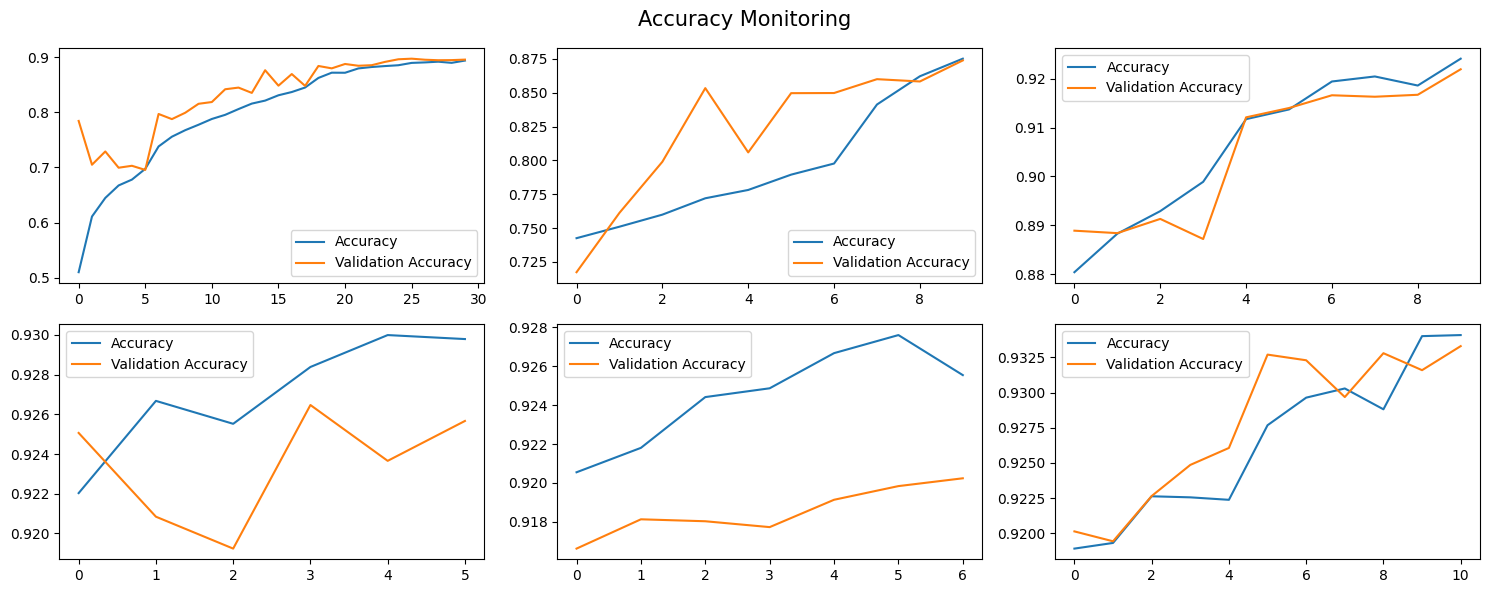

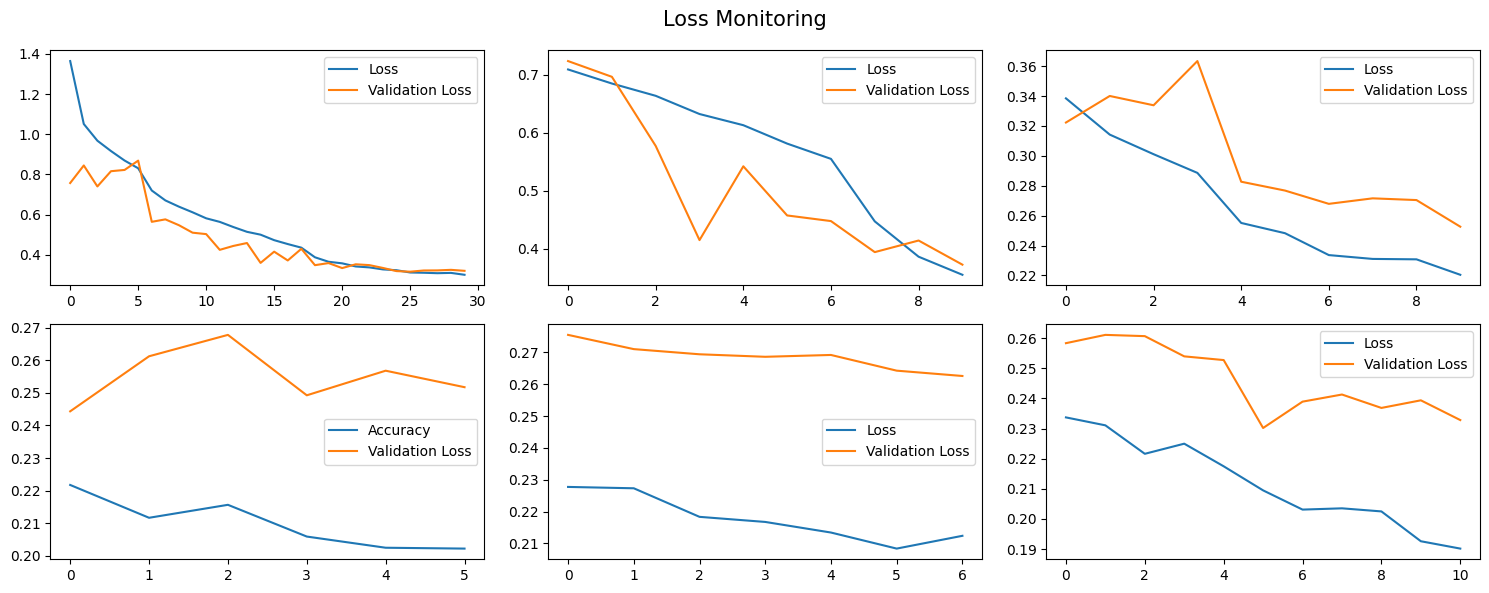

In [21]:
fig,axes=plt.subplots(2,3,figsize=(15,6))
fig.suptitle('Accuracy Monitoring',fontsize=15,fontweight=12)

axes[0][0].plot(history.history['accuracy'],label='Accuracy')
axes[0][0].plot(history.history['val_accuracy'],label='Validation Accuracy')
axes[0][0].legend()

axes[0][1].plot(history_1.history['accuracy'],label='Accuracy')
axes[0][1].plot(history_1.history['val_accuracy'],label='Validation Accuracy')
axes[0][1].legend()

axes[0][2].plot(history_2.history['accuracy'],label='Accuracy')
axes[0][2].plot(history_2.history['val_accuracy'],label='Validation Accuracy')
axes[0][2].legend()

axes[1][0].plot(history_3.history['accuracy'],label='Accuracy')
axes[1][0].plot(history_3.history['val_accuracy'],label='Validation Accuracy')
axes[1][0].legend()

axes[1][1].plot(history_4.history['accuracy'],label='Accuracy')
axes[1][1].plot(history_4.history['val_accuracy'],label='Validation Accuracy')
axes[1][1].legend()

axes[1][2].plot(history_5.history['accuracy'],label='Accuracy')
axes[1][2].plot(history_5.history['val_accuracy'],label='Validation Accuracy')
axes[1][2].legend()

fig.tight_layout()
fig.show()


fig1,axes1=plt.subplots(2,3,figsize=(15,6))
fig1.suptitle('Loss Monitoring',fontsize=15,fontweight=12)

axes1[0][0].plot(history.history['loss'],label='Loss')
axes1[0][0].plot(history.history['val_loss'],label='Validation Loss')
axes1[0][0].legend()

axes1[0][1].plot(history_1.history['loss'],label='Loss')
axes1[0][1].plot(history_1.history['val_loss'],label='Validation Loss')
axes1[0][1].legend()

axes1[0][2].plot(history_2.history['loss'],label='Loss')
axes1[0][2].plot(history_2.history['val_loss'],label='Validation Loss')
axes1[0][2].legend()

axes1[1][0].plot(history_3.history['loss'],label='Accuracy')
axes1[1][0].plot(history_3.history['val_loss'],label='Validation Loss')
axes1[1][0].legend()

axes1[1][1].plot(history_4.history['loss'],label='Loss')
axes1[1][1].plot(history_4.history['val_loss'],label='Validation Loss')
axes1[1][1].legend()

axes1[1][2].plot(history_5.history['loss'],label='Loss')
axes1[1][2].plot(history_5.history['val_loss'],label='Validation Loss')
axes1[1][2].legend()

fig1.tight_layout()
fig1.show()

In [22]:
print(f'Training Accuracy:{model.evaluate(train_data)[1]}')
print(f'Validation Accuracy:{model.evaluate(validation)[1]}')

1245/1245 ━━━━━━━━━━━━━━━━━━━━ 111s 89ms/step - accuracy: 0.9648 - loss: 0.1043
Training Accuracy:0.9666030406951904
312/312 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9008 - loss: 0.3189
Validation Accuracy:0.9326971173286438
